In [1]:
#%matplotlib notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import chi2

import os
import os.path as path
import wget

from tqdm import tqdm
import corner

In [2]:
sample = np.array([0.974,0.950,0.932,1.104,1.038,0.920,0.935,0.907,0.810,0.915])

In [3]:
def Resample(sample):
    resample = np.random.choice(sample, size=len(sample), replace=True)
    return resample

In [4]:
def Bootstrap(sample, n=10000):
    mean_dist = np.zeros(n)
    for i in tqdm(range(n)):
        resample = Resample(sample)
        mean_dist[i] = np.mean(resample)

    return mean_dist

In [5]:
boot = Bootstrap(sample, n=10000)

100%|██████████| 10000/10000 [00:00<00:00, 28532.37it/s]


In [7]:
stdev = np.std(boot)
mu = np.mean(boot)

In [8]:
def gauss(x, mu, stdev):
    return np.exp(-(x - mu)**2 / (2 * stdev**2)) / (np.sqrt(2 * np.pi) * stdev)


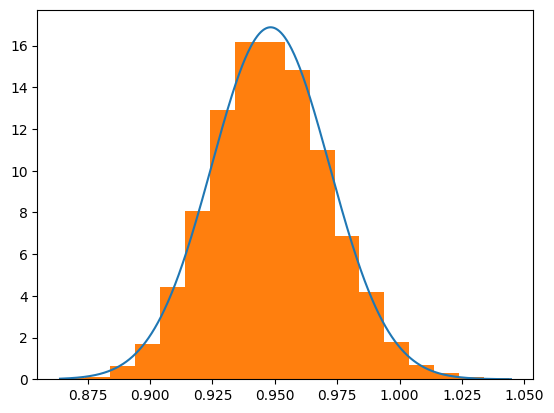

In [9]:
x = np.linspace(np.min(boot), np.max(boot), 1000)
plt.plot(x, gauss(x, mu, stdev))
plt.hist(boot, bins=np.arange(np.min(boot), np.max(boot), 0.01), density=True)
plt.show()


In [12]:
print(1-norm.cdf(1, mu, stdev))

0.014313418008986334


In [3]:
if not path.exists('Data'):
    os.mkdir('Data')
    
file = 'Data/Minimos.dat' 

url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosLineal.txt'
#url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosCuadratico.txt'

if not path.exists(file):
    Path_ = wget.download(url,file)
else:
    Path_ = file


  0% [                                                                                  ]   0 / 522
100% [..................................................................................] 522 / 522

In [11]:
data = np.loadtxt(Path_)
x = data[:,0]
y = data[:,1]
N = len(x)
sigma = np.random.uniform(0,0.2,N)
sigma
print(N)

20


<ErrorbarContainer object of 3 artists>

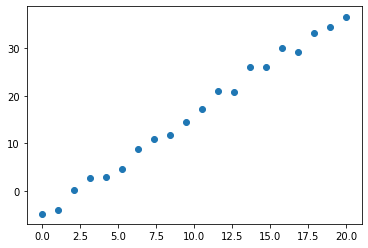

In [12]:
plt.errorbar(x,y,yerr=sigma,fmt='o')

In [13]:
def GetFit(x,y,n=2):
    
    l = x.shape[0]
    b = y
    
    A = np.ones((l,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**i
        
    AT = np.dot(A.T,A)
    bT = np.dot(A.T,b)
    
    xsol = np.linalg.solve(AT,bT)
    
    return xsol

In [18]:
n = 1
param = GetFit(x,y,n)
param

array([-5.12918553,  2.12503681])

In [19]:
def GetModel(x,p):
    
    y = 0
    for n in range(len(p)):
        y += p[n]*x**n
        
    return y

In [20]:
X = sym.Symbol('x',real=True)
GetModel(X,param)

2.12503680800827*x - 5.12918552885299

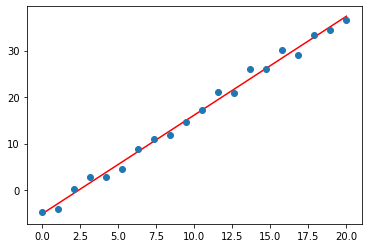

In [21]:
_x = np.linspace(np.min(x),np.max(x),50)

_y = GetModel(_x,param)

plt.errorbar(x,y,yerr=sigma,fmt='o')
plt.plot(_x,_y,color='r')

# Bootstrapping (Bradley Efron 1979)